### Importing all the necessary data:

In [13]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
import calendar
from pandas.plotting import autocorrelation_plot
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
# Importing the data from a CSV File:
data_new = pd.read_csv('data_daily.csv')
data_new['Date'] = pd.to_datetime(data_new['# Date'])
data_new.set_index('Date', inplace=True)

# Create time-based features
data_new['Month'] = data_new.index.month
data_new['Day'] = data_new.index.day

# Create lag features
data_new['Lag_1'] = data_new['Receipt_Count'].shift(1)
data_new['Rolling_Mean_7'] = data_new['Receipt_Count'].rolling(window=7).mean()

# Drop rows with NaN values resulting from lag features
# data_new.dropna(inplace=True)

In [27]:
data_new['Rolling_Mean_7'].fillna(method='bfill', inplace=True)  # Backward fill

In [28]:
data_new['Lag_1'][0]=0

In [29]:
data_new.head()

,# Date,Receipt_Count,Month,Day,Lag_1,Rolling_Mean_7
Date,,,,,,
2021-01-01,2021-01-01,7564766,1,1,0.0,7551300.0
2021-01-02,2021-01-02,7455524,1,2,7564766.0,7551300.0
2021-01-03,2021-01-03,7095414,1,3,7455524.0,7551300.0
2021-01-04,2021-01-04,7666163,1,4,7095414.0,7551300.0
2021-01-05,2021-01-05,7771289,1,5,7666163.0,7551300.0


### Data Check: For Nan's. To see if there are no records scanned for a day.

If there were any Nan's etc, we could apply some Imputation or transformation techniques such as FFill i.e Forward Fill or Backward Fill etc techniques to impute the null value days.

In [76]:
missing_values = data_new.isnull().sum()
missing_values

# Date                0
Receipt_Count         0
Month                 0
Day                   0
Lag_1                 0
Rolling_Mean_7        0
Receipt_Count_Diff    0
dtype: int64

**Obsevration**: We can see that we don't have any Nan's for any respective days.

### To understand our Time Series data much better:
**Time Series Plot**: This plot shows the daily number of scanned receipts over the year. It's essential for identifying overall trends and patterns in the data.

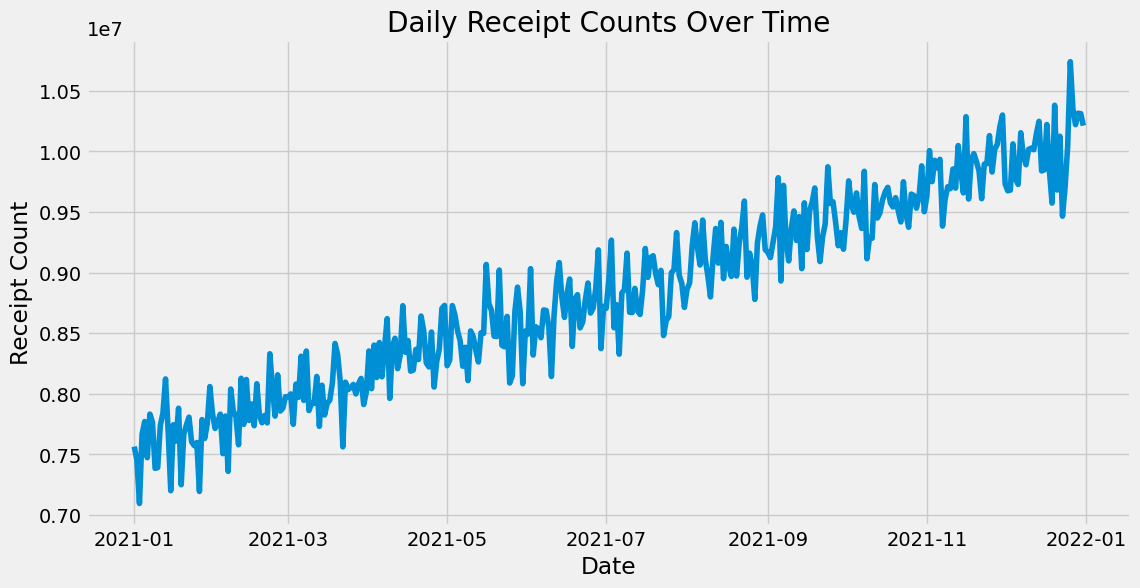

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Receipt_Count', data=data_new)
plt.title('Daily Receipt Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.show()

**Monthly Aggregated Plot**: This bar plot displays the total number of scanned receipts for each month. It's useful for understanding monthly variations and peak periods.

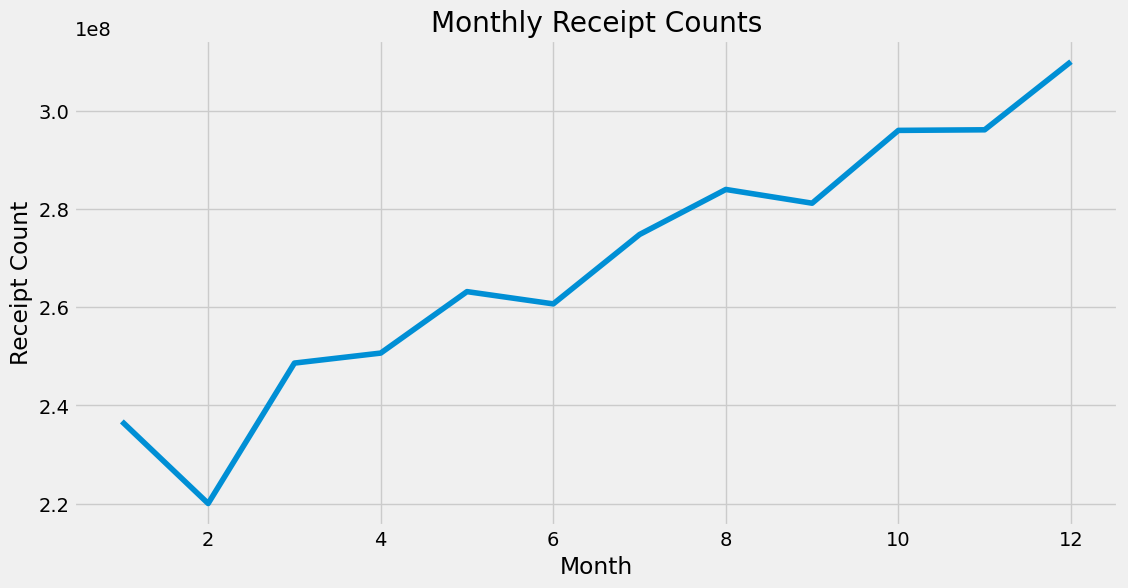

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

monthly_data = data_new.groupby('Month')['Receipt_Count'].sum().reset_index()
monthly_data['Month'] = monthly_data['Month']
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Receipt_Count', data=monthly_data)
plt.title('Monthly Receipt Counts')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.show()

**Box Plot by Month**: The box plot for each month indicates the distribution of daily scans within that month. This helps in identifying any monthly variability and outliers.

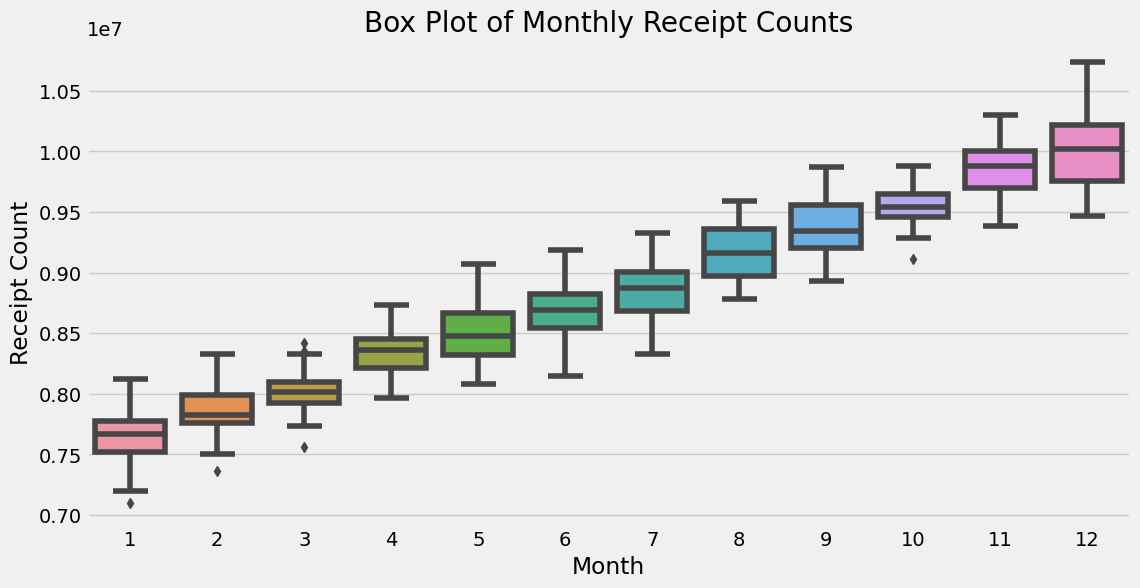

In [89]:
# Box Plot
new_df = pd.read_csv('data_daily.csv')
new_df['Date'] = pd.to_datetime(new_df['# Date'])
new_df.set_index('Date', inplace=True)

# Create a new column 'Month_Year'
new_df['Month_Year'] = new_df.index.to_period('M')

plt.figure(figsize=(12, 6))
sns.boxplot(data=new_df, x=data_new['Month'], y=new_df['Receipt_Count'])
plt.title('Box Plot of Monthly Receipt Counts')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.show()

Autocorrelation Plot: This correlogram indicates whether the data has autocorrelation, meaning if the values on a particular day are correlated with past values. This insight is crucial for time series forecasting.


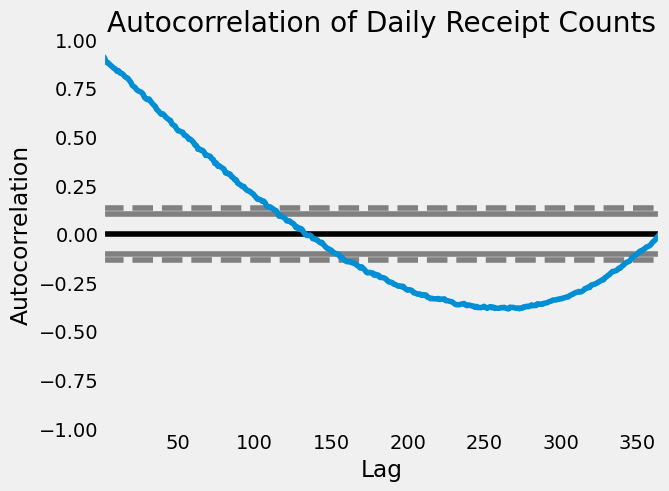

In [85]:
# Autocorrelation Plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_new['Receipt_Count'])
plt.title('Autocorrelation of Daily Receipt Counts')
plt.show()

Interpretaion of this Auto Correlation Plot: The autocorrelation plot (or correlogram) is described shows the autocorrelation of the daily receipt counts at different lag times. Here's how to interpret the plot:

Initial Decline: The autocorrelation starts at 1 when the lag is zero (as anything correlated with itself is perfectly correlated) and typically decreases as the lags increase. This is expected since immediate past values (small lags) are usually more correlated with the present than the distant past.

Significance Bands: The horizontal lines (often dashed) represent significance levels for the autocorrelations. If the autocorrelation value falls outside these bounds, it is statistically significant. In your plot, autocorrelations that extend beyond the dashed lines at any lag suggest that there is significant correlation at that lag.

Negative Autocorrelation: If the autocorrelation dips below zero, as your description suggests it does at higher lags, this indicates a negative correlation at that lag. This could mean that higher values are often followed by lower values at that lag distance, and vice versa.

Long-Term Patterns: If the autocorrelation values show a cyclical pattern or a very gradual decline, this might indicate long-term cyclical effects or seasonality within the data.

Lag Selection for ARIMA: In the context of ARIMA modeling, significant autocorrelations suggest potential candidates for the AR terms (p) in the model. For example, if the first few lags have significant autocorrelation, you might consider an AR term of that order.


Other Plots:
- Day of the Week Analysis: This plot reveals any patterns depending on the day of the week, showing if certain days consistently have higher or lower scans.

### Checking for Stationary:

Checking for stationarity is a crucial step in time series analysis. The Augmented Dickey-Fuller (ADF) test is a common statistical test used to check for stationarity. Here's how you can perform this test on your data_sample dataset:

Steps to Perform the ADF Test
- Import the ADF Test: The ADF test is available in the statsmodels package, specifically in the tseries module.

- Apply the ADF Test: Apply the test to your time series data. The ADF test returns a test statistic and some critical values for different confidence levels.

- Interpret the Results: The null hypothesis of the ADF test is that the time series is non-stationary (has a unit root). If the test statistic is less than the critical value, we reject the null hypothesis, meaning the time series is stationary.

Interpretation:
- ADF Statistic: Lower values (more negative) indicate stronger rejection of the null hypothesis.
- p-value: If the p-value is below a threshold (commonly 0.05), it suggests stationarity.
- Critical Values: Compare the ADF statistic with these values. If the ADF statistic is below the critical value, the series is considered stationary.

In [30]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the 'Receipt_Count' column of your dataset
adf_result = adfuller(data_new['Receipt_Count'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] > 0.05:
    print("Series is non-stationary")
else:
    print("Series is stationary")


ADF Statistic: 0.175044
p-value: 0.970827
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Series is non-stationary


In [31]:
# Differencing the series
data_new['Receipt_Count_Diff'] = data_new['Receipt_Count'].diff().dropna()

# Performing the ADF test again on the differenced data
adf_result_diff = adfuller(data_new['Receipt_Count_Diff'].dropna())  # Make sure to drop NaN after differencing

print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result_diff[1] > 0.05:
    print("Differenced series is non-stationary")
else:
    print("Differenced series is stationary")

ADF Statistic: -8.889819
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Differenced series is stationary


In [32]:
# This data_new has the target feature differenced! Which also means that the time series is not stationary.
data_new

,# Date,Receipt_Count,Month,Day,Lag_1,Rolling_Mean_7,Receipt_Count_Diff
Date,,,,,,,
2021-01-01,2021-01-01,7564766,1,1,0.0,7.551300e+06,NaN
2021-01-02,2021-01-02,7455524,1,2,7564766.0,7.551300e+06,-109242.0
2021-01-03,2021-01-03,7095414,1,3,7455524.0,7.551300e+06,-360110.0
2021-01-04,2021-01-04,7666163,1,4,7095414.0,7.551300e+06,570749.0
2021-01-05,2021-01-05,7771289,1,5,7666163.0,7.551300e+06,105126.0
...,...,...,...,...,...,...,...
2021-12-27,2021-12-27,10350408,12,27,10738865.0,1.001548e+07,-388457.0
2021-12-28,2021-12-28,10219445,12,28,10350408.0,1.009248e+07,-130963.0
2021-12-29,2021-12-29,10313337,12,29,10219445.0,1.011950e+07,93892.0


In [33]:
# To fill out any Nan values instead of excluding them, we can use methods like Backward filing or Forward filling for imputations.
data_new['Receipt_Count_Diff'].fillna(method='bfill', inplace=True)  # Backward fill

### Linear Regression Model using Pytorch:

I wanted to start with a simple model which considers some good amount of input features and provide a good starting point which is free from the overhead complexity etc from the high level libraries which covers the low level details of the problem statement as well as the algorithm.

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

# Selecting the features and target
features = ['Month', 'Day', 'Lag_1', 'Rolling_Mean_7']
X = data_new[features].values.astype(float)  # Features
y = data_new['Receipt_Count_Diff'].values.reshape(-1, 1).astype(float)  # Target

# Normalizing the features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Converting to PyTorch tensors
X_train_tensor = Variable(torch.Tensor(X_train))
X_val_tensor = Variable(torch.Tensor(X_val))
y_train_tensor = Variable(torch.Tensor(y_train))
y_val_tensor = Variable(torch.Tensor(y_val))

# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(len(features), 1)  # Adjust the number of input features

    def forward(self, x):
        return self.linear(x)

# Initialize the model, loss function, and optimizer
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/100, Loss: 1.3545385599136353
Epoch 20/100, Loss: 1.3343924283981323
Epoch 30/100, Loss: 1.316020131111145
Epoch 40/100, Loss: 1.2992523908615112
Epoch 50/100, Loss: 1.2839360237121582
Epoch 60/100, Loss: 1.2699334621429443
Epoch 70/100, Loss: 1.2571187019348145
Epoch 80/100, Loss: 1.2453798055648804
Epoch 90/100, Loss: 1.2346144914627075
Epoch 100/100, Loss: 1.2247309684753418


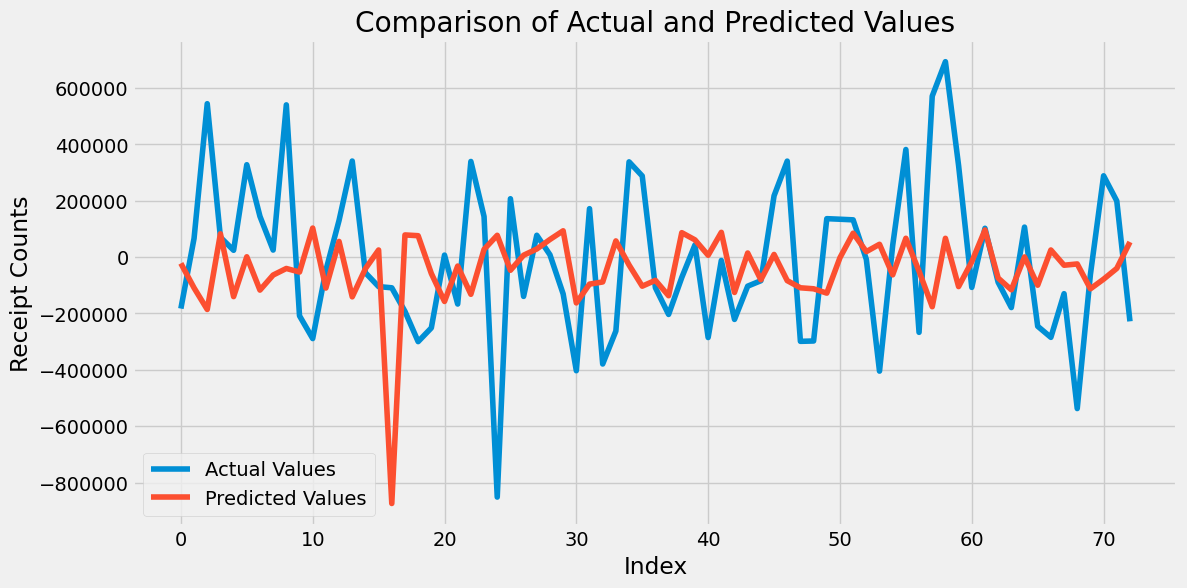

In [94]:
import matplotlib.pyplot as plt

# Predicting on the validation set
with torch.no_grad():
    y_predicted_tensor = model(X_val_tensor)
    y_predicted = y_predicted_tensor.detach().numpy()

# Inverse transform of scaling for predictions and actuals
y_predicted_inv = scaler_y.inverse_transform(y_predicted)
y_val_inv = scaler_y.inverse_transform(y_val_tensor.detach().numpy())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_val_inv, label='Actual Values')
plt.plot(y_predicted_inv, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Receipt Counts')
plt.legend()
plt.show()

In [95]:
from sklearn.metrics import mean_absolute_error

# Predicting on the validation set
with torch.no_grad():
    y_predicted_tensor = model(X_val_tensor)
    y_predicted = y_predicted_tensor.detach().numpy()

# Inverse transform of scaling for predictions and actuals
y_predicted_inv = scaler_y.inverse_transform(y_predicted)
y_val_inv = scaler_y.inverse_transform(y_val_tensor.detach().numpy())

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val_inv, y_predicted_inv)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate RMSE on the original scale
rmse_original = np.sqrt(mean_squared_error(y_predicted_inv, y_val_inv))
print(f'RMSE on original scale: {rmse_original}')


Mean Absolute Error (MAE): 237980.1875
RMSE on original scale: 309986.75


### LSTM's:
LSTMs are a type of recurrent neural network (RNN) architecture designed to handle the shortcomings of traditional RNNs in learning and capturing long-term dependencies in sequential data. They were introduced to overcome the vanishing or exploding gradient problem that occurs when training traditional RNNs on long sequences.

Key components of an LSTM:

Cell State: A memory unit that can store information over long sequences.
Gates: Structures that regulate the flow of information into and out of the cell state.
Forget Gate: Determines what information to discard from the cell state.
Input Gate: Decides what new information to store in the cell state.
Output Gate: Controls what information to output based on the cell state.
LSTMs are designed to selectively remember or forget information over time, making them capable of learning and remembering patterns over longer sequences, which traditional RNNs might struggle with.

Why Use LSTMs for Time Series Forecasting:
Time series forecasting involves predicting future values based on historical data. LSTMs are well-suited for this task due to several reasons:

Long-Term Dependencies: Time series data often contains dependencies that span across long sequences. LSTMs are specialized in capturing and remembering these long-term dependencies, making them effective in understanding patterns in sequential data over time.

Memory and Context Preservation: LSTMs can retain relevant information over extended periods, allowing them to maintain context and remember important patterns from the past in time series data.

Non-Linear Relationships: Time series data can have complex non-linear relationships between past and future values. LSTMs, with their ability to model complex patterns, can capture these intricate relationships effectively.

Flexibility in Sequence Length: LSTMs can handle variable-length sequences, which is crucial in time series forecasting as historical data often comes in sequences of varying lengths.

Feature Extraction: LSTMs can automatically learn relevant features from the data, reducing the need for manual feature engineering in some cases.

In summary, LSTMs are favored for time series forecasting tasks because of their ability to handle long-term dependencies, maintain context over extended sequences, and capture complex patterns in sequential data, making them well-suited for modeling and predicting future values in time-based datasets.

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Assuming 'data_new' is your DataFrame with the additional features
features = ['Month', 'Day', 'Lag_1', 'Rolling_Mean_7']
X = data_new[features].values
y = data_new['Receipt_Count'].values.reshape(-1, 1)

# Normalize the features and target
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler_y.fit_transform(y)

# Function to create sequences including the additional features
def create_sequences(input_data, target_data, seq_length):
    sequences = []
    L = len(input_data)
    for i in range(L - seq_length):
        seq = input_data[i:i + seq_length]
        label = target_data[i + seq_length]
        sequences.append((seq, label))
    return sequences

seq_length = 5  # Sequence length
full_sequences = create_sequences(X_scaled, y_scaled, seq_length)

# Split the sequences into training and validation sets
train_size = int(len(full_sequences) * 0.80)
train_sequences = full_sequences[:train_size]
val_sequences = full_sequences[train_size:]

# Separate X and y for training and validation sets
X_train, y_train = zip(*train_sequences)
X_val, y_val = zip(*val_sequences)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

# Update the LSTM Model to account for the number of features
class LSTM(nn.Module):
    def __init__(self, input_size=len(features), hidden_layer_size=50, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

model = LSTM()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model:
epochs = 150
for epoch in range(epochs):
    for i in range(len(X_train)):
        seq = X_train[i:i+1]
        label = y_train[i:i+1]

        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

epoch: 0 loss: 0.00263783847913146
epoch: 10 loss: 0.003494075033813715
epoch: 20 loss: 0.002705080434679985
epoch: 30 loss: 0.0017737537855282426
epoch: 40 loss: 0.0012512218672782183
epoch: 50 loss: 0.0011678090086206794
epoch: 60 loss: 0.0020406690891832113
epoch: 70 loss: 0.007777232211083174
epoch: 80 loss: 0.011130234226584435
epoch: 90 loss: 0.010997784323990345
epoch: 100 loss: 0.009349140338599682
epoch: 110 loss: 0.007382273208349943
epoch: 120 loss: 0.006291225086897612
epoch: 130 loss: 0.004970697686076164
epoch: 140 loss: 0.00611239904537797


RMSE: 515172.60661231476


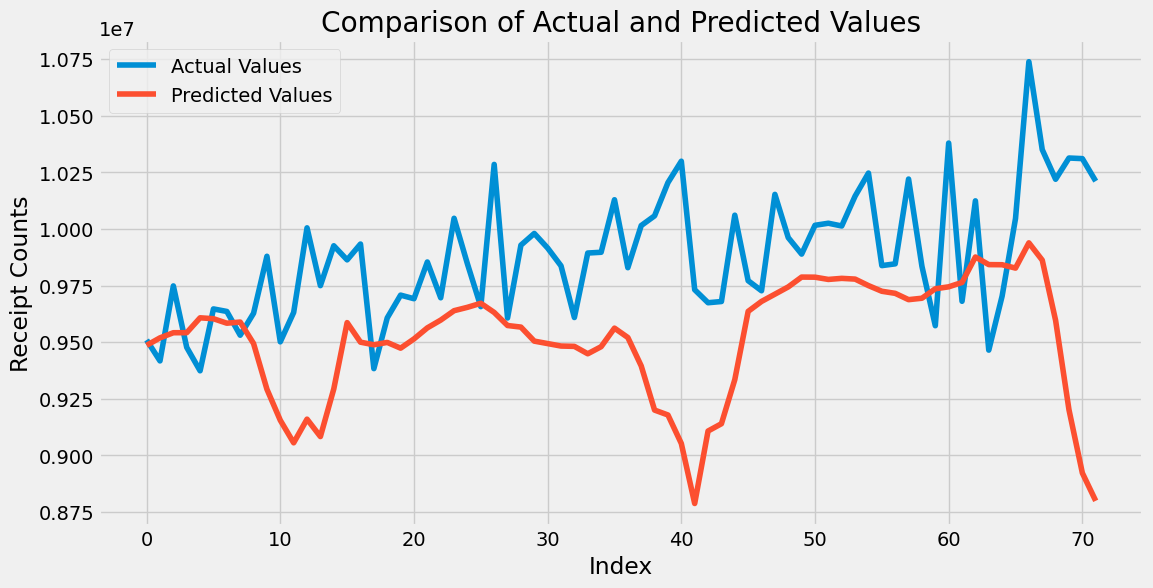

In [75]:
# Predicting on the validation set
model.eval()  # Set the model to evaluation mode
y_pred_val = []
with torch.no_grad():
    for seq in X_val:
        y_pred = model(seq.unsqueeze(0))
        y_pred_val.append(y_pred.item())

# Inverse transform of scaling for predictions and actuals
y_pred_val_scaled = scaler_y.inverse_transform(np.array(y_pred_val).reshape(-1, 1))
y_val_scaled = scaler_y.inverse_transform(y_val.detach().numpy())

# Calculate RMSE
rmse = np.sqrt(np.mean((y_val_scaled - y_pred_val_scaled)**2))
print(f'RMSE: {rmse}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_val_scaled, label='Actual Values')
plt.plot(y_pred_val_scaled, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Receipt Counts')
plt.legend()
plt.show()

Observations from the LSTM Model:

**Tried various Hyper-paramaters and this is as close I was able to train the model and get an RMSE to this extent. My Notebook crashed multiple times for some of the hyper-parametersm so I wasn't able to perform/try to the extent I wanted to. But I tried my level best to show how I implemented LSTM's.**
The loss values from the LSTM training indicate that while the model is learning (the loss is decreasing), the decrease is very gradual and the model might not be learning effectively. This can happen for several reasons:

Underfitting: The model may be too simple to capture the underlying patterns in the data.
Learning Rate: It may be too low, causing slow convergence, or too high, causing the model to miss the optimal solution.
Data Preparation: If the sequences are not capturing relevant temporal patterns, the model may struggle to make accurate predictions.
Epochs: There may not be enough epochs for the model to converge to a good solution.
Batch Size: If the batch size is not appropriate, it can affect how well the model generalizes.
Given the modest decrease in loss, here's what you can try to improve the model's performance:

Increase Model Complexity: Add more LSTM layers or increase the number of neurons in the hidden layers.
Adjust Learning Rate: Experiment with different learning rates. Sometimes a learning rate schedule or learning rate decay can be beneficial.
Sequence Length: Longer sequences can help the model learn more complex patterns, although they require more memory and computation.
Feature Engineering: Additional features that capture relevant information can improve model performance.
Data Shuffling: Shuffling the training data can help the model generalize better.


### ARIMA and SARIMA:
ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are models widely used in time series analysis and forecasting. They're valuable tools for understanding and predicting data points within a time series.

ARIMA (AutoRegressive Integrated Moving Average):
Components:

AutoRegressive (AR) term: Captures the linear relationship between an observation and a number of lagged observations (its own past values).
Integrated (I) term: Represents the differencing of raw observations (subtracting an observation from an observation at the previous time step) to make the time series stationary.
Moving Average (MA) term: Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Why ARIMA?

ARIMA is effective for stationary time series data (where the statistical properties like mean and variance remain constant over time) and can model a wide range of data patterns.
It's useful when the data shows clear patterns in trends and seasonality that can be removed through differencing.
Use Cases:

Forecasting stock prices, weather patterns, economic indicators, etc.
Analyzing and predicting non-stationary time series data by transforming it into a stationary series.
SARIMA (Seasonal ARIMA):
Extension of ARIMA with Seasonality:

SARIMA extends ARIMA by incorporating additional seasonal terms.
It includes seasonal AR and MA terms to model the seasonal component of the time series data.
Components:

Seasonal (S) term: Represents the seasonal component in the data, allowing for modeling seasonality that occurs at regular intervals.
P, D, Q: Similar to ARIMA, SARIMA includes parameters for non-seasonal components (P, D, Q) and seasonal components (p, d, q).
Why SARIMA?

SARIMA is beneficial for time series data exhibiting both non-seasonal and seasonal patterns.
It's suitable for capturing and forecasting time series data that have seasonal fluctuations or periodic patterns.
Use Cases:

Forecasting retail sales affected by seasonal trends, monthly or quarterly business data, seasonal health trends, etc.
Analyzing and predicting time series data where both short-term and long-term patterns are influenced by seasonality.
Both ARIMA and SARIMA models are powerful tools in time series analysis, enabling analysts and data scientists to capture and forecast various types of temporal patterns in data. Their effectiveness lies in their capability to capture different components of time series data and provide valuable insights for forecasting future trends.

 To automate the process of finding the best parameters for a SARIMA model. It uses a grid search over a range of possible values for the ARIMA and seasonal parameters and selects the combination that minimizes the Akaike Information Criterion (AIC), which is a measure of the relative quality of statistical models.

Here's how you can use this approach to find the best parameters for your SARIMA model:

Grid Search: Iterate over combinations of parameters (p, d, q) for the non-seasonal component and (P, D, Q, s) for the seasonal component.
Fit Model: Fit a SARIMA model for each combination of parameters.
Compare Models: Use AIC to compare the models. A lower AIC suggests a better model.
Select the Best Model: Select the parameters that give the lowest AIC.

NOTE: ARIMA and SARIMA models don't require feature scaling like Min-Max or Standard scaling because they are based on the difference in values, which is scale-invariant.

In [68]:
# Assuming you have already differenced your data if needed
# Here, 'Receipt_Count_Diff' is the differenced series
# Split into train and test sets
train_data = data_new['Receipt_Count_Diff'][:int(len(data_new) * 0.8)]
test_data = data_new['Receipt_Count_Diff'][int(len(data_new) * 0.8):]

# Grid search parameters
p = d = q = range(0, 2)  # Non-seasonal parameters
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]  # Seasonal parameters

# Suppress warnings
warnings.filterwarnings("ignore")

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search
for param in itertools.product(p, d, q):
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_data, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print(f'Best SARIMA model: ARIMA{best_pdq}x{best_seasonal_pdq} - AIC:{best_aic}')

# Fit the model with the best parameters
model = SARIMAX(train_data, order=best_pdq, seasonal_order=best_seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
"""
# Forecast
forecasts = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecasts.predicted_mean

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
print(f'RMSE: {rmse}')
"""

Best SARIMA model: ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:7418.81409812437


"\n# Forecast\nforecasts = model_fit.get_forecast(steps=len(test_data))\nforecast_mean = forecasts.predicted_mean\n\n# Calculate RMSE\nrmse = np.sqrt(mean_squared_error(test_data, forecast_mean))\nprint(f'RMSE: {rmse}')\n"

In [88]:
# Last known value of the original, non-differenced series
last_index = train_data.index[-1]  # Get the last index of the training set
last_value = data_new['Receipt_Count'].loc[last_index]  # Use .loc instead of .iloc

# Convert the differenced forecast back to the original scale
#forecast_original = forecast_mean.cumsum() + last_value
forecast_original = np.r_[last_value, forecast_mean].cumsum()[1:]

# To compare with the test set, you need to adjust the test set as well
# Start the cumulative sum from the last value of the training set
test_data_original = test_data.cumsum() + data_new['Receipt_Count'].loc[train_data.index[-1]]


# Calculate RMSE on the original scale
rmse_original = np.sqrt(mean_squared_error(test_data_original, forecast_original))
print(f'RMSE on original scale: {rmse_original}')


RMSE on original scale: 262722.74956602295


Observations: The RMSE seems low considering the volatile nature of the time series data, but linear regression performed well and the overhead complexity is much more simpler for Linear regression when compared to the ARIMA and SARIMA.

### Understanding the Seasonality Component Seperately:

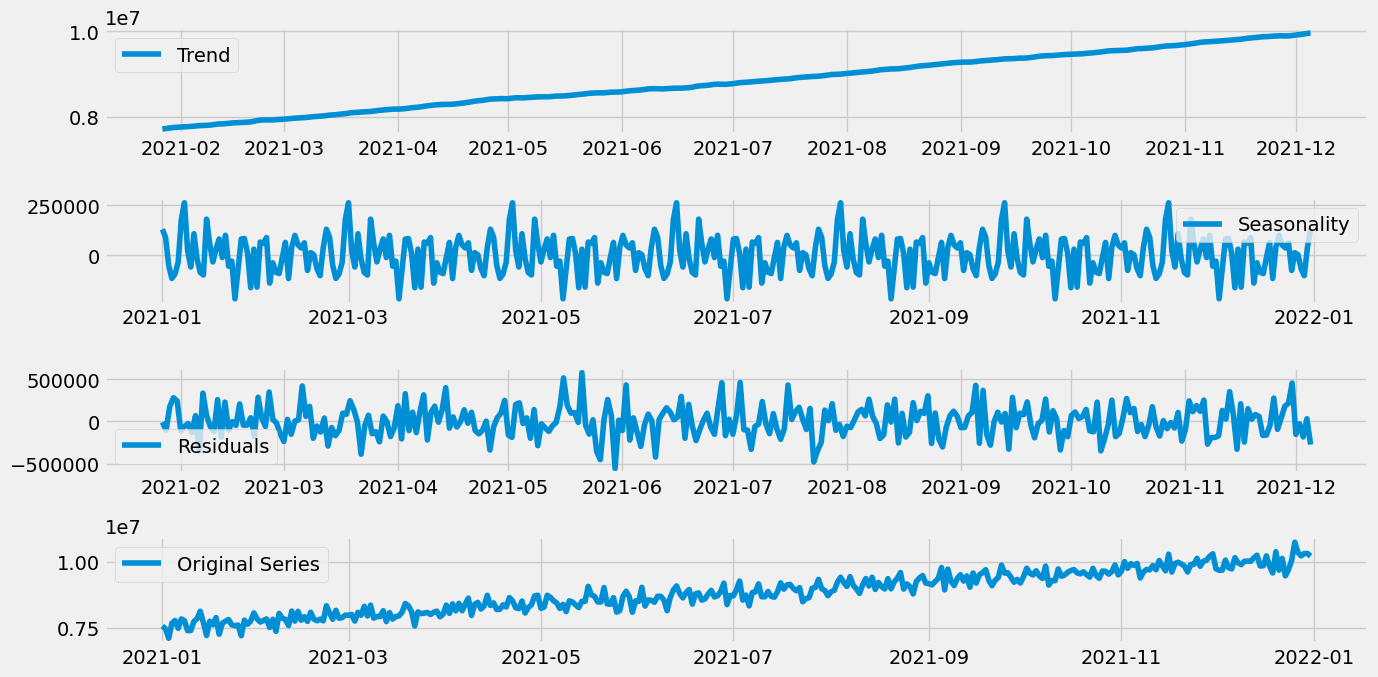

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'Receipt_Count' is the column with the time series data you want to decompose
# and that it is at a daily frequency. If it's not daily, you may need to resample it appropriately.
ts_data = data_new['Receipt_Count']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=52)  # Example for weekly data


# Plot the decomposed components
plt.figure(figsize=(14, 7))

# Trend component
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

# Seasonal component
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')

# Residual component
plt.subplot(413)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

# Original series
plt.subplot(414)
plt.plot(ts_data, label='Original Series')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Here's what you can typically infer from each component:

Trend: This component shows the long-term progression of the data, which often represents the underlying growth or decline. If there's a consistent upward or downward slope in the trend plot, it indicates a long-term increase or decrease in the data.

Seasonality: This component captures the regular pattern that repeats over the defined period. For instance, if you set the period to 12 for monthly data, the seasonality plot should reflect the pattern that repeats every year. Regular peaks and troughs in this plot suggest seasonal effects.

Residuals: These are the irregularities that are not captured by the trend or seasonal components. Ideally, the residuals should be relatively small and random, which would suggest that the trend and seasonal components have captured most of the systematic information in the data.

Original Series: This is your actual data, and it's included for reference so you can compare how well the trend and seasonal components represent the original series.

**FINAL Observations**

- Linear Regression: Satisfied with the performance of the linear regression model, which suggests that the features you engineered (like month, day, lags, and rolling averages) have explanatory power and contribute to predicting the target variable. Linear regression is good for capturing linear relationships but does not capture seasonality or nonlinear patterns inherently.

- LSTM (Long Short-Term Memory): LSTM models are well-suited for time series forecasting because they can capture sequential patterns and long-term dependencies. The issues I faced initially may have been due to the complexity of the model or the need for further hyperparameter tuning. LSTM models can be sensitive to the scale of the data, the architecture of the neural network, and the length of the input sequences.

- SARIMA (Seasonal AutoRegressive Integrated Moving Average): The SARIMA model is designed specifically for time series data with seasonality. From your description, it seems that there was a systematic offset in the predictions. This could have been due to incorrect parameter choices, inadequate seasonal differencing, or challenges with integrating the differenced forecasts back to the original scale.


### Results(NOT NORMALIZED RMSE RESULT):
- Based on comparing RMSE, Sarima and Linear Regression seems efficient considering the volatility of the data. Comparing MAE i.e Mean Absolute Error, Linear Regression performs better than LSTM and SARIMA.

- Comparing the Execution, ease and reduced overhead complexity of various functions, I think considering Linear Regression might be a better fit for our solution.



In [96]:
import pandas as pd

# Create a dictionary with models and their RMSE values
data = {
    'Model': ['SARIMA', 'LSTM', 'Linear Regression'],
    'RMSE': [262722.74956602295, 515172.60661231476, 309986.75]
}

# Create a DataFrame
rmse_df = pd.DataFrame(data)

# Set the model names as the index for better readability
rmse_df.set_index('Model', inplace=True)

# Output the DataFrame to see the table
print(rmse_df)

                            RMSE
Model                           
SARIMA             262722.749566
LSTM               515172.606612
Linear Regression  309986.750000


# Training the model to Forecast 2022 year data points!

### Training Linear Regression on the whole dataset and then forecasting for the whole 2022 year:

In [97]:
# Assuming that 'data_new' is a DataFrame that contains the features and target variable for 2021
# and that the necessary preprocessing has been done as per previous discussions

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Selecting the features and target for the entire 2021 dataset
features = ['Month', 'Day', 'Lag_1', 'Rolling_Mean_7']
X = data_new[features].values.astype(float)  # Features from 2021
y = data_new['Receipt_Count'].values.reshape(-1, 1).astype(float)  # Target from 2021

# Normalizing the features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors for the entire dataset
X_tensor = torch.Tensor(X_scaled)
y_tensor = torch.Tensor(y_scaled)

# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_dim = X.shape[1]  # Number of input features
model = LinearRegressionModel(input_dim)

# Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model on the entire 2021 dataset
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/100, Loss: 0.33424612879753113
Epoch 20/100, Loss: 0.3198734223842621
Epoch 30/100, Loss: 0.30659711360931396
Epoch 40/100, Loss: 0.2943163812160492
Epoch 50/100, Loss: 0.2829405963420868
Epoch 60/100, Loss: 0.27238819003105164
Epoch 70/100, Loss: 0.2625857889652252
Epoch 80/100, Loss: 0.25346723198890686
Epoch 90/100, Loss: 0.24497300386428833
Epoch 100/100, Loss: 0.2370494306087494


ValueError: ignored

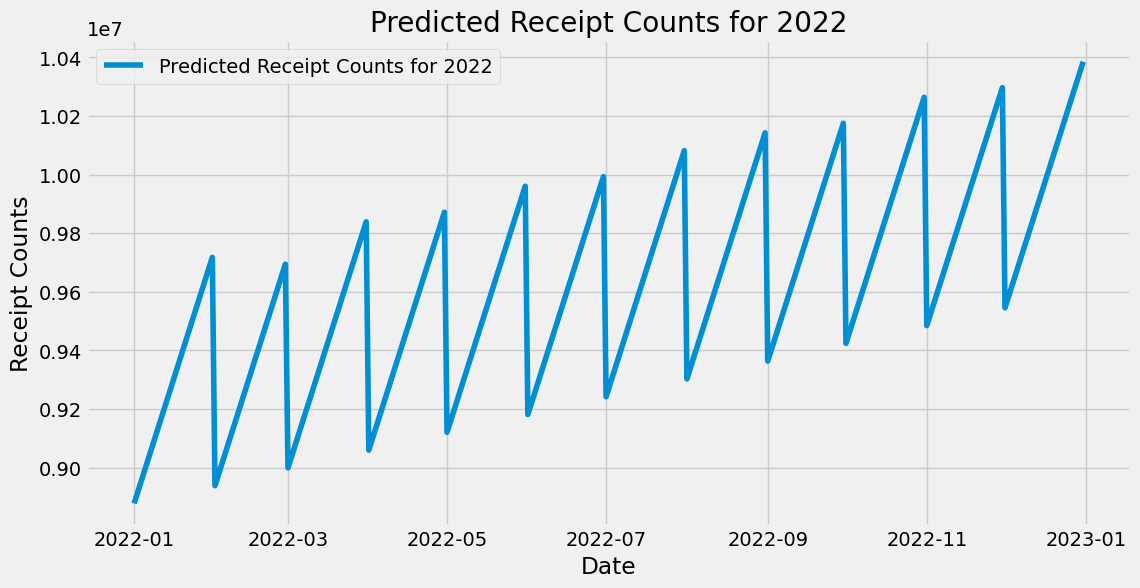

In [98]:

# Predict for 2022
# Prepare the DataFrame for the entire 2022 predictions
dates_2022 = pd.date_range(start='2022-01-01', periods=365)
predictions_data = pd.DataFrame(index=dates_2022)
predictions_data['Month'] = predictions_data.index.month
predictions_data['Day'] = predictions_data.index.day

# Generating features for 2022 assuming the pattern repeats from 2021
predictions_data['Lag_1'] = y[-1].item()  # The last known receipt count
predictions_data['Rolling_Mean_7'] = np.mean(y[-7:]).item()  # The rolling mean of the last 7 days of 2021

# Scale the 2022 features
features_2022 = predictions_data[features].values.astype(float)
features_2022_scaled = scaler_X.transform(features_2022)

# Convert scaled features to PyTorch tensor
features_2022_tensor = torch.Tensor(features_2022_scaled)

# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions_tensor = model(features_2022_tensor)
    predictions_2022 = scaler_y.inverse_transform(predictions_tensor.numpy())

# The predictions for 2022
predictions_2022 = predictions_2022.flatten()

# Plot the predicted values for 2022
plt.figure(figsize=(12, 6))
plt.plot(dates_2022, predictions_2022, label='Predicted Receipt Counts for 2022')
plt.title('Predicted Receipt Counts for 2022')
plt.xlabel('Date')
plt.ylabel('Receipt Counts')
plt.legend()
plt.show()

In [99]:
features_2022_tensor

tensor([[-1.6027, -1.6735,  1.5626,  2.0124],
        [-1.6027, -1.5598,  1.5626,  2.0124],
        [-1.6027, -1.4461,  1.5626,  2.0124],
        ...,
        [ 1.5876,  1.5097,  1.5626,  2.0124],
        [ 1.5876,  1.6234,  1.5626,  2.0124],
        [ 1.5876,  1.7370,  1.5626,  2.0124]])

In [100]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Define your dataset here
# data_new = ...

# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Assuming 'data_new' is a DataFrame that includes the 'Receipt_Count' column for 2021
# Prepare features for the whole of 2021
features = ['Month', 'Day', 'Lag_1', 'Rolling_Mean_7']
X = data_new[features].values.astype(float)  # Features from 2021
y = data_new['Receipt_Count'].values.reshape(-1, 1).astype(float)  # Targets from 2021

# Normalizing the features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors for the entire dataset
X_tensor = torch.Tensor(X_scaled)
y_tensor = torch.Tensor(y_scaled)

# Initialize the model
input_dim = X.shape[1]  # Number of input features
model = LinearRegressionModel(input_dim)

# Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model on the entire 2021 dataset
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 10/100, Loss: 1.9680373668670654
Epoch 20/100, Loss: 1.779767632484436
Epoch 30/100, Loss: 1.6115474700927734
Epoch 40/100, Loss: 1.4612289667129517
Epoch 50/100, Loss: 1.3268948793411255
Epoch 60/100, Loss: 1.2068339586257935
Epoch 70/100, Loss: 1.099517583847046
Epoch 80/100, Loss: 1.003581166267395
Epoch 90/100, Loss: 0.9178066253662109
Epoch 100/100, Loss: 0.8411064147949219


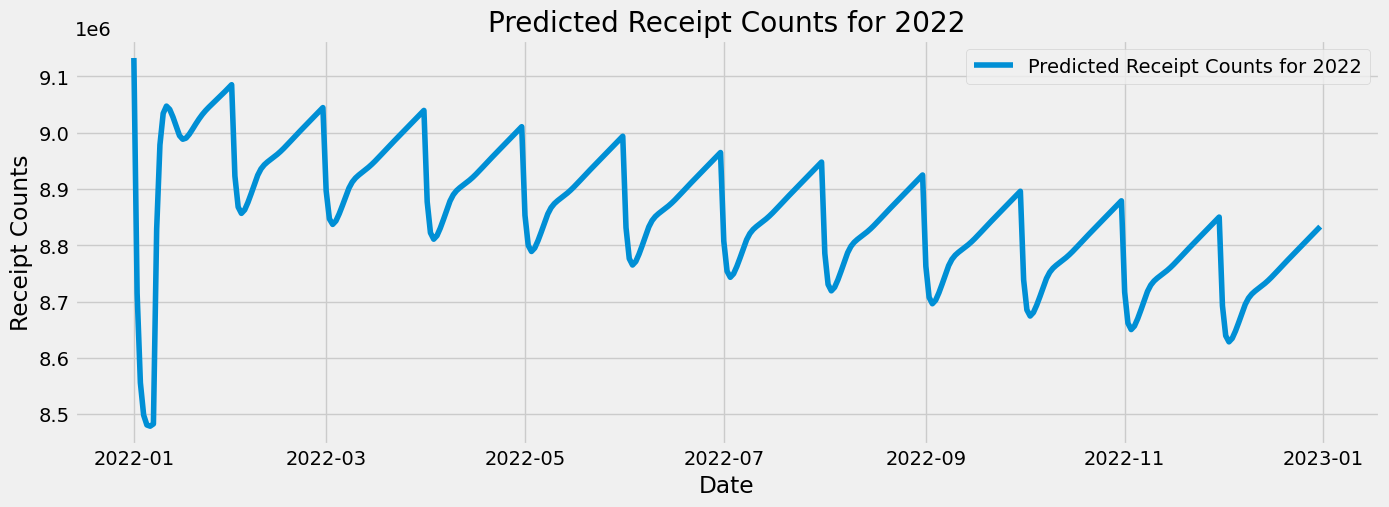

In [101]:
# Prepare the DataFrame for the entire 2022 predictions
dates_2022 = pd.date_range(start='2022-01-01', periods=365)
predictions_2022 = pd.DataFrame(index=dates_2022)
predictions_2022['Month'] = predictions_2022.index.month
predictions_2022['Day'] = predictions_2022.index.day

# Initialize the lag features using the last known data from 2021
last_known_receipt = data_new['Receipt_Count'].iloc[-1]
rolling_mean_7 = data_new['Receipt_Count'].tail(7).mean()

# Container for the predictions
predicted_receipt_counts = []

# Predict day by day
for current_date in dates_2022:
    # Update the features for the current prediction date
    current_features = {
        'Month': current_date.month,
        'Day': current_date.day,
        'Lag_1': last_known_receipt,
        'Rolling_Mean_7': rolling_mean_7
    }
    current_features = scaler_X.transform([list(current_features.values())])

    # Predict the receipt count for the current day
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        current_features_tensor = torch.Tensor(current_features)
        predicted_count_scaled = model(current_features_tensor)
        predicted_count = scaler_y.inverse_transform(predicted_count_scaled.numpy())

    # Save the prediction
    predicted_receipt_counts.append(predicted_count.item())

    # Update the lag features for the next prediction
    last_known_receipt = predicted_count.item()
    if len(predicted_receipt_counts) >= 7:
        rolling_mean_7 = np.mean(predicted_receipt_counts[-7:])

# The predicted_receipt_counts list now holds the predicted values for each day in 2022

# Plot the predicted values for 2022
plt.figure(figsize=(15, 5))
plt.plot(dates_2022, predicted_receipt_counts, label='Predicted Receipt Counts for 2022')
plt.title('Predicted Receipt Counts for 2022')
plt.xlabel('Date')
plt.ylabel('Receipt Counts')
plt.legend()
plt.show()

**Observations**: Based on the  predicted receipt counts for 2022, here are a few observations:

- Trend: The model seems to be capturing some form of trend over time. The predicted values are oscillating, which might indicate the model is responding to some periodic changes in the data.

- Seasonality: The predictions show a recurring pattern, suggesting that the model might be capturing some seasonality. However, without knowing the nature of the original data, it's hard to determine if this seasonality aligns with real-world seasonal trends.

- Regularization Need: If the predictions are not closely aligning with actual observed values or if there is concern about overfitting, regularization methods like Lasso (L1) or Ridge (L2) could potentially improve the model by penalizing its complexity and making it generalize better.

- Volatility: There appears to be some volatility in the predictions, particularly noticeable with the sharp peaks and troughs. If these do not reflect actual fluctuations in the data, it might be a sign that the model is too sensitive to the input features or noise in the data.

- Scale of Predictions: The predictions do not show extreme values, which is good as it suggests the model is not producing wildly unrealistic numbers. However, the scale of the y-axis seems to show that the predictions are within a relatively tight range, which could be a sign that the model is underfitting if the actual data has a wider range.

- Data Quality: It's important to ensure that the quality of the features used for making predictions is high. Any errors in feature calculation, especially Lag_1 and Rolling_Mean_7, could significantly impact the predictions.

- Potential Improvements: To potentially improve the predictions, consider using other machine learning models or time series forecasting models that can better capture complex patterns. Additionally, explore feature engineering, hyperparameter tuning, and including external variables that may influence the receipt counts.

In [102]:
predictions_2022['Predicted_Receipt_Count'] = predicted_receipt_counts


In [103]:
predictions_2022

,Month,Day,Predicted_Receipt_Count
2022-01-01,1,1,9132573.0
2022-01-02,1,2,8714794.0
2022-01-03,1,3,8555933.0
2022-01-04,1,4,8498517.0
2022-01-05,1,5,8480848.0
...,...,...,...
2022-12-27,12,27,8809287.0
2022-12-28,12,28,8815241.0
2022-12-29,12,29,8821203.0
2022-12-30,12,30,8827169.0


In [104]:
predictions_2022.to_csv('predicted_receipt_counts_2022.csv')

In [105]:
# Generating a requirements.txt file!
!pip freeze > requirements.txt

In [106]:
data_new.head()

,# Date,Receipt_Count,Month,Day,Lag_1,Rolling_Mean_7,Receipt_Count_Diff
Date,,,,,,,
2021-01-01,2021-01-01,7564766,1,1,0.0,7551300.0,-109242.0
2021-01-02,2021-01-02,7455524,1,2,7564766.0,7551300.0,-109242.0
2021-01-03,2021-01-03,7095414,1,3,7455524.0,7551300.0,-360110.0
2021-01-04,2021-01-04,7666163,1,4,7095414.0,7551300.0,570749.0
2021-01-05,2021-01-05,7771289,1,5,7666163.0,7551300.0,105126.0
